In [ ]:
# Step 1: Setup & Imports

!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Step 2: Dataset Paths

data_dir = "PlantDoc-Dataset"  # this is the folder of the repo you cloned
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Note: The GitHub repo has `train` and `test` folders. :contentReference[oaicite:3]{index=3}


# Step 3: Transforms

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    # (Optional) normalize, but you should compute mean/std or use ImageNet's
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


# Step 4: Load Dataset using ImageFolder

full_train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

print("Classes:", full_train_dataset.classes)
num_classes = len(full_train_dataset.classes)

# If you want to split train into train + val:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


# Step 5: Model (ResNet18 Transfer Learning)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


# Step 6: Loss + Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Step 7: Training Loop

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")


# Step 8: Test Evaluation

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


# Step 9: Save Model

torch.save(model.state_dict(), "plantdoc_resnet18.pth")
print("Model saved to plantdoc_resnet18.pth")


# Step 10: Inference / Predict on New Image

def predict_leaf(image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img = transform_test(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    class_name = full_train_dataset.classes[pred.item()]
    return class_name

# Example
# print(predict_leaf("path_to_some_leaf_image.jpg"))


Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 3.45 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.
Using device: cuda
Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


Epoch 1/15, Train Loss: 2.5112
Validation Loss: 1.6077, Validation Acc: 0.5330
Epoch 2/15, Train Loss: 1.3717
Validation Loss: 1.3146, Validation Acc: 0.6055
Epoch 3/15, Train Loss: 0.9202
Validation Loss: 1.1601, Validation Acc: 0.6418
Epoch 4/15, Train Loss: 0.6375
Validation Loss: 1.1142, Validation Acc: 0.6141
Epoch 5/15, Train Loss: 0.4494
Validation Loss: 1.0837, Validation Acc: 0.6461
Epoch 6/15, Train Loss: 0.3241
Validation Loss: 1.1631, Validation Acc: 0.6141
Epoch 7/15, Train Loss: 0.2279
Validation Loss: 1.1764, Validation Acc: 0.6503
Epoch 8/15, Train Loss: 0.1795
Validation Loss: 1.0896, Validation Acc: 0.6695
Epoch 9/15, Train Loss: 0.1435
Validation Loss: 1.1697, Validation Acc: 0.6119
Epoch 10/15, Train Loss: 0.1146
Validation Loss: 1.1217, Validation Acc: 0.6525
Epoch 11/15, Train Loss: 0.1019
Validation Loss: 1.1345, Validation Acc: 0.6631
Epoch 12/15, Train Loss: 0.0979
Validation Loss: 1.2010, Validation Acc: 0.6482
Epoch 13/15, Train Loss: 0.0801
Validation Loss: 

In [3]:
train_losses = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):

    # -------- TRAIN --------
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    # -------- VALIDATION --------
    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/15, Train Loss: 0.0651
Val Loss: 1.1651, Val Acc: 0.6525
Epoch 2/15, Train Loss: 0.0548
Val Loss: 1.3065, Val Acc: 0.6461
Epoch 3/15, Train Loss: 0.0513
Val Loss: 1.2413, Val Acc: 0.6525
Epoch 4/15, Train Loss: 0.0475
Val Loss: 1.3146, Val Acc: 0.6418
Epoch 5/15, Train Loss: 0.0541
Val Loss: 1.3332, Val Acc: 0.6311
Epoch 6/15, Train Loss: 0.0540
Val Loss: 1.3285, Val Acc: 0.6354
Epoch 7/15, Train Loss: 0.0542
Val Loss: 1.3055, Val Acc: 0.6226
Epoch 8/15, Train Loss: 0.0461
Val Loss: 1.2746, Val Acc: 0.6461
Epoch 9/15, Train Loss: 0.0413
Val Loss: 1.2249, Val Acc: 0.6631
Epoch 10/15, Train Loss: 0.0345
Val Loss: 1.2579, Val Acc: 0.6525
Epoch 11/15, Train Loss: 0.0335
Val Loss: 1.3279, Val Acc: 0.6354
Epoch 12/15, Train Loss: 0.0405
Val Loss: 1.2889, Val Acc: 0.6418
Epoch 13/15, Train Loss: 0.0420
Val Loss: 1.2968, Val Acc: 0.6567
Epoch 14/15, Train Loss: 0.0327
Val Loss: 1.3045, Val Acc: 0.6546
Epoch 15/15, Train Loss: 0.0288
Val Loss: 1.2649, Val Acc: 0.6610


In [4]:
train_losses
val_losses
val_accs


[0.652452025586354,
 0.6460554371002132,
 0.652452025586354,
 0.6417910447761194,
 0.6311300639658849,
 0.6353944562899787,
 0.6226012793176973,
 0.6460554371002132,
 0.6631130063965884,
 0.652452025586354,
 0.6353944562899787,
 0.6417910447761194,
 0.6567164179104478,
 0.6545842217484008,
 0.6609808102345416]

In [7]:
!ls /content


PlantDoc-Dataset  plantdoc_resnet18.pth  sample_data


In [8]:
!ls /content/PlantDoc-Dataset


LICENSE.txt  PlantDoc_Examples.png  README.md  test  train


In [9]:
train_dir = "/content/PlantDoc-Dataset/train"
test_dir  = "/content/PlantDoc-Dataset/test"


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

print("Classes:", train_dataset.classes)
print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))


Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']
Train images: 2342
Test images: 236


Using: cuda
Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']
Train: 2342 images
Test: 236 images
Epoch 1/4 | Train Loss: 2.2835 | Test Loss: 1.9971 | Test Acc: 0.4364
Epoch 2/4 | Train Loss: 0.9925 | Test Loss: 1.7967 | Test Acc: 0.4703
Epoch 3/4 | Train Loss: 0.4629 | Test Loss: 1.7419 | Test Acc: 0.5508
Epoch 4/4 | Train Loss: 0.2153 | Test Loss: 1.7411 | Test Acc: 0.5085


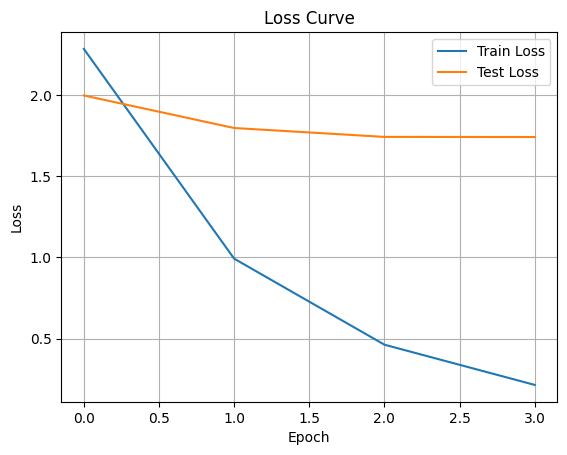

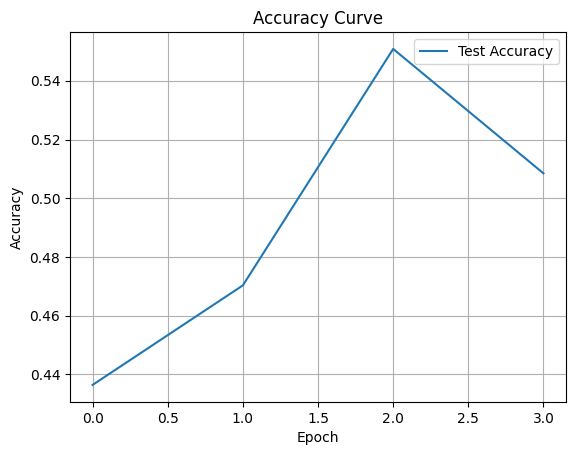

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------------
# 1. PATHS
# -----------------------------
train_dir = "/content/PlantDoc-Dataset/train"
test_dir  = "/content/PlantDoc-Dataset/test"

# -----------------------------
# 2. TRANSFORMS & LOADERS
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(train_dir, transform=transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

classes = train_ds.classes
num_classes = len(classes)

print("Classes:", classes)
print("Train:", len(train_ds), "images")
print("Test:", len(test_ds),  "images")

# -----------------------------
# 3. MODEL
# -----------------------------
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# For plotting
train_losses = []
test_losses = []
test_accs = []

epochs = 4

# -----------------------------
# 4. TRAIN LOOP
# -----------------------------
for epoch in range(epochs):
    model.train()
    running_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # =====================
    # TEST
    # =====================
    model.eval()
    test_loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            test_loss_total += loss.item() * imgs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_test_loss = test_loss_total / len(test_loader.dataset)
    epoch_test_acc = correct / total

    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Test Acc: {epoch_test_acc:.4f}")

# -----------------------------
# 5. PLOT LOSS
# -----------------------------
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# 6. PLOT ACCURACY
# -----------------------------
plt.figure()
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()


Using: cuda
Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']
Train: 2342 images
Test: 236 images
Epoch 1/10 | Train Loss: 2.7716 | Test Loss: 2.3699 | Test Acc: 0.3347
Epoch 2/10 | Train Loss: 1.7383 | Test Loss: 2.0307 | Test Acc: 0.4280
Epoch 3/10 | Train Loss: 1.2964 | Test Loss: 1.8928 | Test Acc: 0.4661
Epoch 4/10 | Train Loss: 1.0367 | Test Loss: 1.7830 | Test Acc: 0.4915
Epoch 5/10 | Train Loss: 0.8299

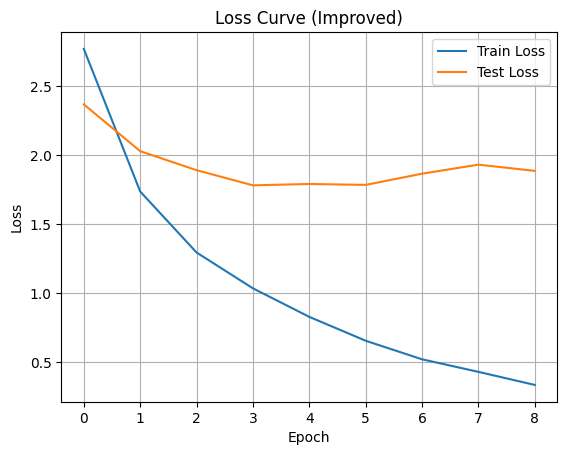

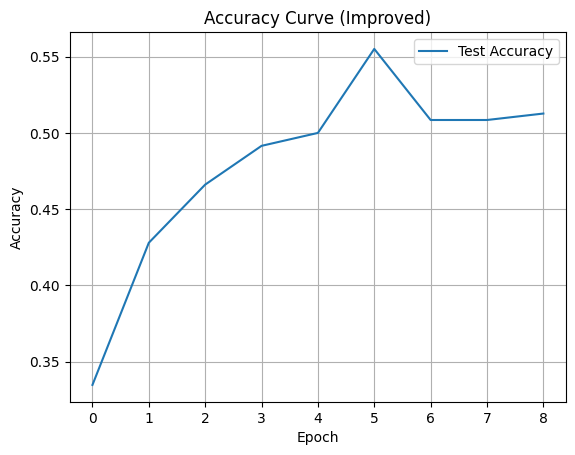

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# --- 0. CONFIGURATION & DEVICE ---
# Set seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------------
# 1. PATHS
# -----------------------------
train_dir = "/content/PlantDoc-Dataset/train"
test_dir  = "/content/PlantDoc-Dataset/test"

# -----------------------------
# 2. IMPROVED TRANSFORMS & LOADERS
# -----------------------------
# Standardize mean and standard deviation for ImageNet pre-trained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Apply Data Augmentation to the training set (KEY CHANGE!)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Flips the image horizontally
    transforms.RandomRotation(15),     # Rotates the image randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalization (KEY CHANGE!)
])

# Use only necessary transforms for the testing set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # Normalization (KEY CHANGE!)
])

train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

classes = train_ds.classes
num_classes = len(classes)

print("Classes:", classes)
print("Train:", len(train_ds), "images")
print("Test:", len(test_ds),  "images")

# -----------------------------
# 3. MODEL (Added Dropout)
# -----------------------------
model = models.resnet18(pretrained=True)

# Freeze all layers first (Optional but good for initial training)
# for param in model.parameters():
#     param.requires_grad = False

# Modify the fully connected layer (Added a Dropout layer for regularization!)
model.fc = nn.Sequential(
    nn.Dropout(0.5), # Regularization (KEY CHANGE!)
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

# Weight decay (L2 Regularization) added to the optimizer (KEY CHANGE!)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005) # L2 Regularization

# For plotting and Early Stopping
train_losses = []
test_losses = []
test_accs = []
best_test_loss = float('inf')
patience = 5 # Number of epochs to wait for improvement (KEY CHANGE!)
patience_counter = 0

epochs = 10 # Increased epochs since we have regularization now

# -----------------------------
# 4. TRAIN LOOP (Added Early Stopping)
# -----------------------------
for epoch in range(epochs):
    # Training phase (Your original code)
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluation phase (Your original code)
    model.eval()
    test_loss_total = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss_total += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_test_loss = test_loss_total / len(test_loader.dataset)
    epoch_test_acc = correct / total

    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.4f}")

    # --- EARLY STOPPING CHECK (KEY CHANGE!) ---
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        patience_counter = 0
        # Optional: Save the best model state
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"Early Stopping counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}!")
            break

# -----------------------------
# 5. PLOT LOSS
# -----------------------------
# (Plotting code remains the same)
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Improved)")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# 6. PLOT ACCURACY
# -----------------------------
# (Plotting code remains the same)
plt.figure()
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve (Improved)")
plt.legend()
plt.grid()
plt.show()

In [16]:
# =====================
# TEST
# =====================
model.eval()
test_loss_total = 0
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        test_loss_total += loss.item() * imgs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# <--- THIS LINE MUST BE ALIGNED HERE
epoch_test_loss = test_loss_total / len(test_loader.dataset)
epoch_test_acc = correct / total
# <--- AND THIS LINE MUST BE ALIGNED HERE

test_losses.append(epoch_test_loss)
test_accs.append(epoch_test_acc)

Using: cuda
Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']
Train: 2342 images
Test: 236 images
Epoch 1/50 | Train Loss: 2.7560 | Test Loss: 2.2981 | Test Acc: 0.3771 | LR: 1.0e-04
Epoch 2/50 | Train Loss: 1.7127 | Test Loss: 2.0350 | Test Acc: 0.4322 | LR: 1.0e-04
Epoch 3/50 | Train Loss: 1.2849 | Test Loss: 1.8894 | Test Acc: 0.4915 | LR: 1.0e-04
Epoch 4/50 | Train Loss: 1.0319 | Test Loss: 1.7648 | Test A

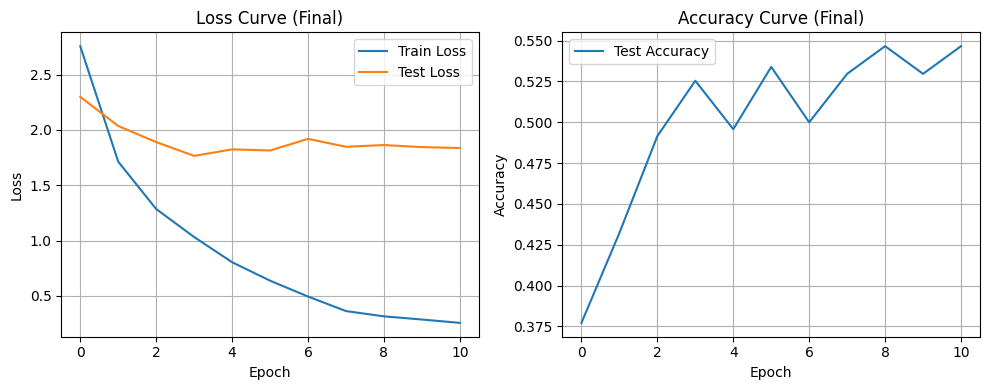

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import the Scheduler
import matplotlib.pyplot as plt

# --- 0. CONFIGURATION & DEVICE ---
torch.manual_seed(42) # Set seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------------
# 1. PATHS
# -----------------------------
# Assuming paths are correct based on your output
train_dir = "/content/PlantDoc-Dataset/train"
test_dir  = "/content/PlantDoc-Dataset/test"

# -----------------------------
# 2. TRANSFORMS & LOADERS
# -----------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Consistent Transforms for Testing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_transform)

# Increased num_workers for faster data loading
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

classes = train_ds.classes
num_classes = len(classes)

print("Classes:", classes)
print("Train:", len(train_ds), "images")
print("Test:", len(test_ds),  "images")

# -----------------------------
# 3. MODEL, LOSS, OPTIMIZER, & SCHEDULER
# -----------------------------
model = models.resnet18(pretrained=True)

# Modify FC layer with Dropout for Regularization
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Adam Optimizer with L2 Regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)

# Learning Rate Scheduler (FIXED: verbose=True removed)
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.2,
                              patience=2)

# For plotting and Early Stopping
train_losses = []
test_losses = []
test_accs = []
best_test_loss = float('inf')
patience = 7 # Early Stopping patience
patience_counter = 0

epochs = 50

# -----------------------------
# 4. TRAIN LOOP
# -----------------------------
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluation Phase
    model.eval()
    test_loss_total = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss_total += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_test_loss = test_loss_total / len(test_loader.dataset)
    epoch_test_acc = correct / total

    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)

    # Step the Learning Rate Scheduler
    scheduler.step(epoch_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Test Acc: {epoch_test_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")

    # --- EARLY STOPPING CHECK ---
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        patience_counter = 0
        # Optional: Save the best model state here
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1} due to non-improving Test Loss.")
            break

# -----------------------------
# 5. PLOT RESULTS
# -----------------------------

## Loss Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Final)")
plt.legend()
plt.grid()

## Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve (Final)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()